Maximizing overlap between signal and template.
Frequency Domain. (Draft)

In [1]:
#Necessary packages for the study
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_fd_waveform
from pycbc.waveform.parameters import Parameter
from pycbc.filter import match
from pycbc.filter import matchedfilter


#Function which generates the templatefor a given masses
def template_waveform(mass1,mass2):
 
    hp_non_eccen, _ = get_fd_waveform(approximant="TaylorF2",
                                       mass1=mass1,
                                       mass2=mass2,
                                       f_lower=20.0,
                                       delta_f=1.0)
    
    hp_non_eccen.resize(1024) #Resize to avoid problems while computing overlap
    
    hp_non_eccen /= max(abs(hp_non_eccen)) #Normalizing

    return hp_non_eccen

/home/raulrgdg/pycbc/venv/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Starting the optimization problem with a Grid Search

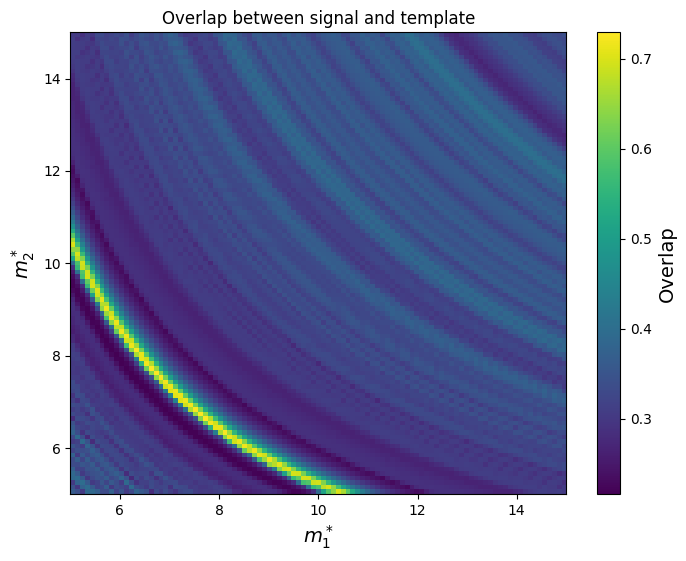

Results of the maximizing process: 

Best masses: m1= 6.6 , m2= 7.7  

Max overlap=  0.7291273880529248


Signal parameters: 

M=  15 

Mchirp=  6.0836434189320565 

q=  0.5 

Template parameters with the best overlap: 

M=  14.3 

Mchirp=  6.202311711693683 

q=  1.1666666666666667 



In [2]:
#Optimization Method: Grid Search

num_points = 101 #grid length

#Generating the grid
masses_grid = np.linspace(5, 15, num_points)  #(solar masses)

#Eccentric Signal
s_m1 = 5
s_m2 = 10
s_chirpmass=(s_m1*s_m2)**(3/5)/(s_m1+s_m2)**(1/5)
s_e = 0.1
s_q=s_m1/s_m2

hp_eccen, _ = get_fd_waveform(approximant="TaylorF2Ecc",
                                mass1=s_m1,
                                mass2=s_m2,
                                eccentricity=s_e,  
                                spin1z=0.0,
                                spin2z=0.0,
                                f_lower=20.0,
                                delta_f=1.0)

hp_eccen.resize(1024)
hp_eccen /= max(abs(hp_eccen))



overlap_matrix = np.zeros((num_points, num_points))
max_overlap = -1
best_masses =[]

#Computing overlap between each pair of masses of the grid and the signal
for i, mass1 in enumerate(masses_grid):
    for j, mass2 in enumerate(masses_grid):
        hp_non_eccen=template_waveform(mass1,mass2)
        
        overlap, _ = match(hp_eccen, hp_non_eccen, psd=None, low_frequency_cutoff=20.0, high_frequency_cutoff=1024.0, subsample_interpolation=True)
        overlap_matrix[i, j] = overlap
        
        if overlap > max_overlap:
            max_overlap = overlap
            (t_m1,t_m2) = (mass1, mass2)

#Template parameters
t_chirpmass=(t_m1*t_m2)**(3/5)/(t_m1+t_m2)**(1/5)
t_q=t_m2/t_m1

#Plotting as a heatmap
plt.figure(figsize=(8, 6))
cax=plt.imshow(overlap_matrix, extent=(masses_grid.min(), masses_grid.max(), masses_grid.min(), masses_grid.max()), origin='lower', aspect='auto', cmap='viridis')
cbar = plt.colorbar(cax)
cbar.set_label('Overlap', fontsize=14)
plt.xlabel(r'$m_1^*$', fontsize=14)
plt.ylabel(r'$m_2^*$', fontsize=14)
plt.title(fr'Overlap between signal and template') #: $m_1$={s_m1} , $m_2$= {s_m2}
plt.savefig('Grid-101-5-15_e1')
plt.show()


#Results
print('Results of the maximizing process: \n')
print('Best masses: m1=',t_m1,', m2=',t_m2,' \n')
print('Max overlap= ', max_overlap)

#Saving the matrix computed
np.save('overlap_matrix_e01', overlap_matrix)
np.save('masses_grid', masses_grid)
print('\n')

#Showing relevant values computed
print('Signal parameters: \n')
print('M= ', s_m1+s_m2,'\n')
print('Mchirp= ', s_chirpmass,'\n')
print('q= ', s_q,'\n')

print('Template parameters with the best overlap: \n')
print('M= ', t_m1+t_m2,'\n')
print('Mchirp= ', t_chirpmass,'\n')
print('q= ', t_q,'\n')


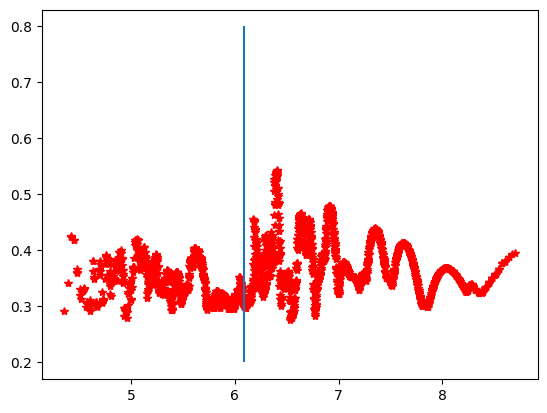

In [3]:
#Plotting chirp mass vs overlap to check any tendency

num_points = 70 #Grid length

#Generating the grid 
masses_grid = np.linspace(5, 10, num_points)  # (solar masses)

#Signal
s_m1 = 5
s_m2 = 10
s_chirpmass=(s_m1*s_m2)**(3/5)/(s_m1+s_m2)**(1/5)
s_e = 0.3
s_q=s_m2/s_m1

hp_eccen, _ = get_fd_waveform(approximant="TaylorF2Ecc",
                                mass1=s_m1,
                                mass2=s_m2,
                                eccentricity=s_e,  
                                spin1z=0.0,
                                spin2z=0.0,
                                f_lower=20.0,
                                delta_f=1.0)

hp_eccen.resize(1024)
hp_eccen /= max(abs(hp_eccen))



overlap_matrix = np.zeros((num_points, num_points))
max_overlap = -1
best_masses =[]

#Computing overlap between each pair of masses of the grid and the signal
for i, mass1 in enumerate(masses_grid):
    for j, mass2 in enumerate(masses_grid):
        if mass2>mass1:
            overlap_matrix[i,j]=0
            continue
        hp_non_eccen=template_waveform(mass1,mass2)
        
        overlap, _ = match(hp_eccen, hp_non_eccen, psd=None, low_frequency_cutoff=20.0, high_frequency_cutoff=1024.0, subsample_interpolation=False)
        overlap_matrix[i, j] = overlap
        
        if overlap > max_overlap:
            max_overlap = overlap
            (t_m1,t_m2) = (mass1, mass2)


#Template
t_chirpmass=(t_m1*t_m2)**(3/5)/(t_m1+t_m2)**(1/5)
t_q=t_m2/t_m1

#Plotting overlap vs mchirp
n=len(overlap_matrix)
overlap_valid =[]
m_valid=[]
chirpmasses=[]
for i,m1 in enumerate(masses_grid):
    for j,m2 in enumerate(masses_grid):
        if j>i:
            continue
        overlap_valid.append(overlap_matrix[i,j])
        chirpmass=(m1*m2)**(3/5)/(m1+m2)**(1/5)
        chirpmasses.append(chirpmass)
plt.plot(chirpmasses, overlap_valid, 'r*')
plt.vlines(6.0836,0.2,0.8) #Value of the signal's chirp mass (in order to identify any tendency)

#Saving the data computed
np.save('chirpmasses_e-0.3.npy', chirpmasses)
np.save('overlapvalid_e-0.3.npy', overlap_valid)




In [4]:
#Optimization method: after looking interesting points with th Grid Search, we use Scipcy.minimize (Nelder-Mead method)

from scipy.optimize import minimize

hp_eccen, _ = get_fd_waveform(approximant="EccentricFD",
                                mass1=s_m1,
                                mass2=s_m2,
                                eccentricity=s_e,  
                                spin1z=0.0,
                                spin2z=0.0,
                                f_lower=20.0,
                                delta_f=1.0)
hp_eccen.resize(1024)
hp_eccen /= max(abs(hp_eccen))

#Objective function; which generates the templates and computes the overlap
def objective_function(masses):
    mass1,mass2=masses
    hp_non_eccen=template_waveform(mass1,mass2)   
    #Computing overlap and returning their negative value (minimizing a negative value = maximizing)
    overlap, _ = match(hp_eccen, hp_non_eccen, psd=None, low_frequency_cutoff=20.0, high_frequency_cutoff=1024.0, subsample_interpolation=False)
    return -overlap

#Callback to check to status of the optimization process
def callback(xk):
    mass1, mass2 = xk
    overlap = -objective_function([mass1, mass2])
    print(f"Overlap: {overlap}, masas: {xk}")
    if overlap >= 0.99:
        print("Tolerancia al overlap alcanzada.")
        return True
    return False

#Initial masses
initial_guess = [7, 7] 

#Optimization
result = minimize(objective_function, initial_guess, method='Nelder-Mead', callback=callback)

print("Resultado de la optimización:") 
print(result)

Overlap: 0.3313984070389185, masas: [7. 7.]
Overlap: 0.3526627117639626, masas: [7.   6.65]
Overlap: 0.3526627117639626, masas: [7.   6.65]
Overlap: 0.3526627117639626, masas: [7.   6.65]
Overlap: 0.3930282415732902, masas: [6.86875 6.86875]
Overlap: 0.39404542661465464, masas: [7.21875 6.51875]
Overlap: 0.39404542661465464, masas: [7.21875 6.51875]
Overlap: 0.39404542661465464, masas: [7.21875 6.51875]
Overlap: 0.39404542661465464, masas: [7.21875 6.51875]
Overlap: 0.3941949177157311, masas: [7.12851563 6.60351562]
Overlap: 0.3941949177157311, masas: [7.12851563 6.60351562]
Overlap: 0.3941949177157311, masas: [7.12851563 6.60351562]
Overlap: 0.3941949177157311, masas: [7.12851563 6.60351562]
Overlap: 0.3941949177157311, masas: [7.12851563 6.60351562]
Overlap: 0.3942394813940607, masas: [7.06400146 6.66478271]
Overlap: 0.394277816834832, masas: [7.14158936 6.58924561]
Overlap: 0.394277816834832, masas: [7.14158936 6.58924561]
Overlap: 0.394277816834832, masas: [7.14158936 6.58924561]
O

In [5]:
#New optimization algorithm: Differential Evolution 

from scipy.optimize import differential_evolution

#Signal
hp_eccen, _ = get_fd_waveform(approximant="EccentricFD",
                                mass1=5,
                                mass2=10,
                                eccentricity=0.2,  
                                spin1z=0.0,
                                spin2z=0.0,
                                f_lower=20.0,
                                delta_f=1.0)
hp_eccen.resize(1024)
hp_eccen /= max(abs(hp_eccen))


def objective_function(x):
    q,mchirp=x #For a given 

    mass2=(1+q)**(1/5) * q**(2/5) * mchirp
    mass1=(1+q)**(1/5) * q**(-3/5) * mchirp
    
    hp_non_eccen=template_waveform(mass1,mass2)   
    overlap, _ = match(hp_eccen, hp_non_eccen, psd=None, low_frequency_cutoff=20.0, high_frequency_cutoff=1024.0, subsample_interpolation=False)
    return -overlap

def callback(xk, convergence):
    q, mchirp = xk
    overlap = -objective_function([q, mchirp])
    print(f"Overlap: {overlap}, masas: {xk}")
    if convergence <0.00001:
        print("Tolerancia al overlap alcanzada.")
        return True
    return False

#Here the key is that we must specify the bounds;
# we choose [0.1,1] for the mass ratio, taking into account most part of the range, 
# and [5.8,6.5] for the chirp mass, taking into account the interesting interval showed before. 

bounds=[(0.1,1.0),(5.8,6.5)]
results=[]
for i in range(2):
    bounds=[(0.1,1.5),(5.8,6.5)]
    results.append(differential_evolution(objective_function, bounds, callback=callback)) #Saving the data in a list

Overlap: 0.5522961669973916, masas: [0.27873537 6.09812813]
Overlap: 0.5522961669973916, masas: [0.27873537 6.09812813]
Overlap: 0.552337649437609, masas: [0.34537282 6.12444948]
Overlap: 0.552337649437609, masas: [0.34537282 6.12444948]
Overlap: 0.552337649437609, masas: [0.34537282 6.12444948]
Overlap: 0.552337649437609, masas: [0.34537282 6.12444948]
Overlap: 0.5638456221894554, masas: [0.3606916  6.12508668]
Overlap: 0.5640022364146943, masas: [0.43492278 6.14915777]
Overlap: 0.5640022364146943, masas: [0.43492278 6.14915777]
Overlap: 0.5680083132728767, masas: [0.39824638 6.1362362 ]
Overlap: 0.5699552253890505, masas: [0.41378857 6.14097091]
Overlap: 0.5699552253890505, masas: [0.41378857 6.14097091]
Overlap: 0.5701460828790306, masas: [0.41379271 6.14143735]
Overlap: 0.5701460828790306, masas: [0.41379271 6.14143735]
Overlap: 0.5701460828790306, masas: [0.41379271 6.14143735]
Overlap: 0.5178594410926642, masas: [1.37209542 6.32334813]
Overlap: 0.5178594410926642, masas: [1.37209

'To improve your chances of finding a global minimum use higher `popsize`
    values'